# Lecture 7

* GAM for regression 
* GAM for classification
* Regression decision trees
* Classification decision trees
* Gradient trees boosting (XGBOOST)

Import necessary libraries:

In [2]:
import numpy as np
import pandas as pd
import random
import math
import sklearn.datasets as ds
from sklearn.cross_validation import train_test_split
from ml_metrics import rmse

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from JSAnimation import IPython_display
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Generalized additive models (regression)

In this section we will see how backfitting algorithm works. We are going to use cubic spline approximation as our building block algorithm.

In [16]:
boston = ds.load_boston()
X = boston.data
y = boston.target/50.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
print 'Number of training examples: ' + str(X.shape[0])
print 'Number of features: ' + str(X.shape[1])

Number of training examples: 506
Number of features: 13


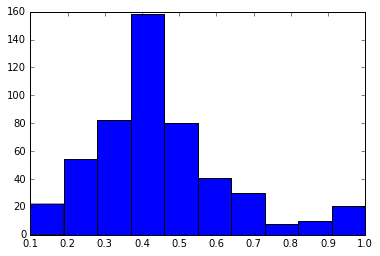

In [17]:
plt.hist(y)
plt.show()

Now we train generalized additive model with backfitting algorithm. The built-in function UnivariateSpline from scipy package is used as a building block of the backfitting algorithm:

In [6]:
from scipy.interpolate import UnivariateSpline

In [7]:
alpha = np.mean(y_train)
fj = [] #no splines at the beginning
niter = 100
for it in range(niter):
    for var in range(X_train.shape[1]):
        fj_values = np.transpose(np.array([f(X_train[:,j]) for j,f in enumerate(fj) if j != var])).reshape((X_train.shape[0], -1))
        z = y_train - alpha - np.sum(fj_values, axis=1)
        df = pd.DataFrame()
        df['x'] = np.round(X_train[:,var], 1)
        df['y'] = z        
        df.sort_values(by='x', inplace=True)
        df = df.groupby('x')['y'].mean().reset_index()
        # the main step of backfitting algorithm:
        if it == 0:
            fj.append(UnivariateSpline(df.x.values, df.y.values, k=min(len(df)-1,3)))
        else:
            fj[var] = UnivariateSpline(df.x.values, df.y.values, k=min(len(df)-1,3))

In [8]:
fj

The result will be the set of cubic splines for each variable saved in the list fj. Now we check the accuracy on the test set:

In [9]:
fj_values = np.transpose(np.array([f(X_test[:,j]) for j,f in enumerate(fj)])).reshape((X_test.shape[0], -1))
y_pred = alpha + np.sum(fj_values, axis=1)
print rmse(y_test, y_pred)

0.100600863408


# Generalized additive models (classification)

In this section we implement GAM for logistic regression and weighted backfitting algorithm.

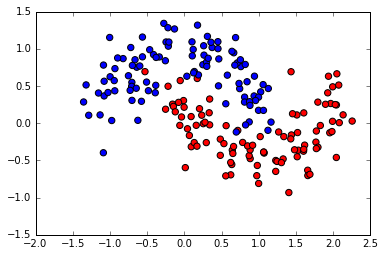

In [10]:
np.random.seed(0)
X, y = ds.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

In [11]:
fj = [] #no splines at the beginning
niter = 100
for it in range(niter):
    y_mean = np.mean(y)
    alpha = np.log(y_mean/(1-y_mean))
    if it == 0:
        eta = np.array([alpha]*X.shape[0])
    else:
        fj_values = np.transpose(np.array([f(X[:,j]) for j,f in enumerate(fj) if j != var])).reshape((X.shape[0], -1))
        eta = np.array([alpha]*X.shape[0]) + np.sum(fj_values, axis=1)
    mu = 1.0/(1 + np.exp(-1.0*eta))
    z = eta + (y - mu)/(mu*(1-mu))
    w = np.multiply(mu, 1.0-mu)
    alpha_z = np.mean(z)
    for var in range(X.shape[1]):
        fj_values = np.transpose(np.array([f(X[:,j]) for j,f in enumerate(fj) if j != var])).reshape((X.shape[0], -1))
        zz = z - alpha_z - np.sum(fj_values, axis=1)
        df = pd.DataFrame()
        df['x'] = np.round(X[:,var], 1)
        df['y'] = zz
        df['w'] = w
        df.sort_values(by='x', inplace=True)
        df = df.groupby('x')[['y', 'w']].mean().reset_index()
        # the main step of weighted backfitting algorithm:
        if it == 0:
            fj.append(UnivariateSpline(df.x.values, df.y.values, df.w.values, k=min(len(df)-1,3)))
        else:
            fj[var] = UnivariateSpline(df.x.values, df.y.values, df.w.values, k=min(len(df)-1,3))
    alpha = alpha_z

In [12]:
def plot_decision_boundary(X, y, alpha, fj, xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1):
    fig = plt.figure(figsize=(6,6))
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    X_test = np.c_[x1.ravel(), x2.ravel()]
    fj_values = np.transpose(np.array([f(X_test[:,j]) for j,f in enumerate(fj)])).reshape((X_test.shape[0], -1))
    ypred = 1.0/(1.0 + np.exp(-alpha - np.sum(fj_values, axis=1)))
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    #plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

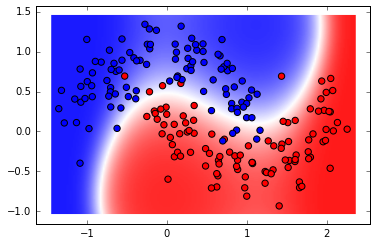

In [13]:
plot_decision_boundary(X, y, alpha, fj, xmin=np.min(X[:,0])-0.1, xmax=np.max(X[:,0])+0.1, ymin=np.min(X[:,1])-0.1, ymax=np.max(X[:,1])+0.1)

## Regression decision tree

First, we use the built-in implementation of the decision tree in python. 

In [11]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from graphviz import Source
import pydot

We will use Boston dataset from scikit-learn package.

In [12]:
boston = ds.load_boston()
X = boston.data
y = boston.target/50.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Fit the model (notice that we use parameter max\_depth to restrict the tree size):

In [13]:
clf = DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X_train, y_train)

Now we visualize the resulted tree:

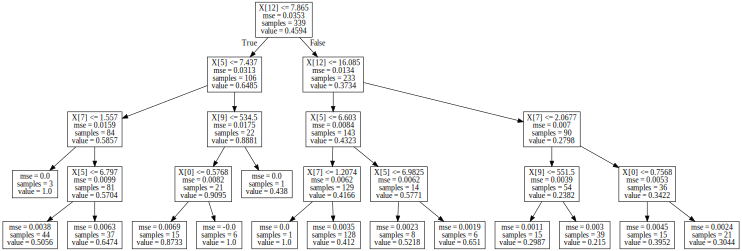

In [14]:
export_graphviz(clf, out_file='regression_tree_scikit.dot') #produces dot file
dot = open('regression_tree_scikit.dot').read()
dot = dot.replace('node [shape=box] ;', 'node [shape=box] ;\ngraph [size="10.3,10.3!"];')
dot = Source(dot)
dot
#### another way to save it to png file and use matplotlib ####
#from StringIO import StringIO
#from scipy import misc
#dotfile = StringIO()
#export_graphviz(clf, out_file=dotfile)
#pydot.graph_from_dot_data(dotfile.getvalue()).write_png("dtree.png")
#plt.figure(figsize=(30,10))
#plt.imshow(misc.imread('dtree.png'))
#plt.show()

In [15]:
y_pred = clf.predict(X_test)
print rmse(y_test, y_pred)

0.0771597318202


We are going to show a simple implementation of decision tree algorithm from scratch. There are different possibilities to implement the decision tree in Python. We will create two classes for node and tree, accordingly. Node class contains the description of each node and pointer to father and daughter nodes, and tree will contain all nodes and functions for splitting and predicton. As a bonus I have added the function that saves tree structure in the dot file.

In [18]:
class Node():
    def __init__(self, id, samples, prediction, error, father_node=None):
        if father_node is None: ### it means that the node is a root node
            self.depth = 0
        else:
            self.depth = father_node.depth + 1
        self.father_node = father_node
        self.id = id
        self.samples = np.array(samples)
        self.prediction = prediction
        self.error = error
        self.j = None
        self.t = None

class RegressionTree():
    def __init__(self, X, y, max_depth=5, min_samples_leaf = 1):
        self.X = X
        self.y = y
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.nodes = []
        mu, err = self.error(y)
        self.nodes.append(Node(0, [x for x in range(X.shape[0])], mu, err))
        self.nodes_to_split = [0]

    def error(self, y):
        p = np.mean(y)
        return p, np.mean(np.power(y-p, 2))
        
    def split_next_node(self):
        if len(self.nodes_to_split) == 0:
            return
        node = self.nodes[self.nodes_to_split[0]]
        del self.nodes_to_split[0]
        if (node.depth >= self.max_depth or len(node.samples)<=2*self.min_samples_leaf-1):
            node.left = None
            node.right = None
            return
        best_j = -999
        best_t = -999
        best_se1 = node.error*len(node.samples)
        best_se2 = node.error*len(node.samples)
        best_mu1 = -999
        best_mu2 = -999
        for j in range(self.X.shape[1]):
            Xj = self.X[node.samples,j]
            Xj_min = np.min(Xj)
            Xj_max = np.max(Xj)
            for t in np.linspace(Xj_min, Xj_max, 300):
                y_left = self.y[node.samples][Xj<t]
                y_right = self.y[node.samples][Xj>=t]
                if (len(y_left)<self.min_samples_leaf or len(y_right)<self.min_samples_leaf):
                    continue
                mu1, mse1 = self.error(y_left)
                mu2, mse2 = self.error(y_right)
                se1 = mse1*len(y_left)
                se2 = mse2*len(y_right)
                if (se1 + se2) < (best_se1 + best_se2):
                    best_j = j
                    best_t = t
                    samples_left = node.samples[Xj<t]
                    samples_right = node.samples[Xj>=t]
                    best_mu1 = mu1
                    best_mu2 = mu2
                    best_se1 = se1
                    best_se2 = se2
                    best_mse1 = mse1
                    best_mse2 = mse2
        if best_j == -999:
            node.left = None
            node.right = None
        else:
            node.left = Node(len(self.nodes), samples_left, best_mu1, best_mse1, node)
            node.right = Node(len(self.nodes)+1, samples_right, best_mu2, best_mse2, node)
            node.j = best_j
            node.t = best_t
            self.nodes.append(node.left)
            self.nodes.append(node.right)
            self.nodes_to_split.append(len(self.nodes)-2)
            self.nodes_to_split.append(len(self.nodes)-1)
    
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            node = self.nodes[0]
            while True:
                if node.j is None:
                    preds.append(node.prediction)
                    break
                if X[i, node.j] < node.t:
                    node = node.left
                else:
                    node = node.right
        return preds
    
    def save_tree_to_dot(self, filename):
        def get_edge(x):
            if x.j is None:
                label = 'mse = ' + str(np.round(x.error,3)) + '\n samples = ' + str(len(x.samples)) + '\n value = ' + str(np.round(x.prediction,3))
            else:
                label = 'X[' + str(x.j) + '] < ' + str(np.round(x.t)) + '\n mse = ' + str(np.round(x.error,3)) + '\n samples = ' + str(len(x.samples)) + '\n value = ' + str(np.round(x.prediction,3))
            if x.father_node is None:
                return str(x.id) + ' [ label="' + label + '"] ;\n'
            else:
                return str(x.id) + ' [ label="' + label + '"] ;\n' + str(x.father_node.id) + ' -> ' + str(x.id) + ' ;\n' 

        f = open(filename, 'w')
        f.write('digraph Tree {\n node [shape = box] ;\n graph [size="9.7,8.3!"];\n')
        for x in self.nodes:
            f.write(get_edge(x))
        f.write('}')
        f.close()
        

In [19]:
tree = RegressionTree(X_train, y_train, max_depth=4, min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
tree.save_tree_to_dot('regression_tree_manual.dot')

Check the error on the test set:

In [20]:
rmse(y_test, tree.predict(X_test))

0.07209792520517698

We can also draw the tree from the dot file (remember that we saved tree in the dot file already):

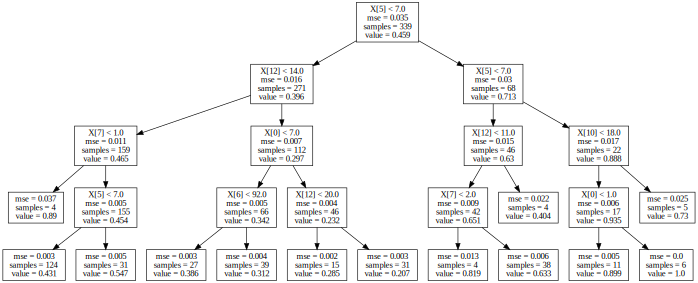

In [21]:
dot = Source(open('regression_tree_manual.dot').read())
dot

## Classification decision tree

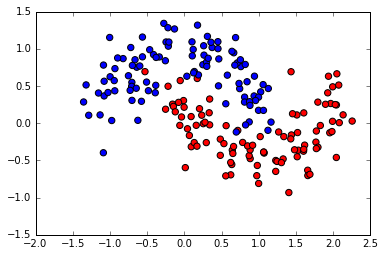

In [22]:
np.random.seed(0)
X, y = ds.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We will use the function plot\_decision\_boundary() to see the result of our classifiction:

In [23]:
def plot_decision_boundary(model, xmin=-0.1, xmax=1.1, ymin=-0.1, ymax=1.1):
    fig = plt.figure(figsize=(6,6))
    x1, x2 = np.meshgrid(np.linspace(xmin, xmax, 500),
                         np.linspace(ymin, ymax, 500))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    extent = xmin, xmax, ymin, ymax
    
    #plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.imshow(ypred, cmap=cm.bwr, alpha=.9, interpolation='bilinear', extent = extent, origin='lower')
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm.bwr)

Scikit-learn has its own implementation of classification decision trees:

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4)
clf = clf.fit(X_train, y_train)

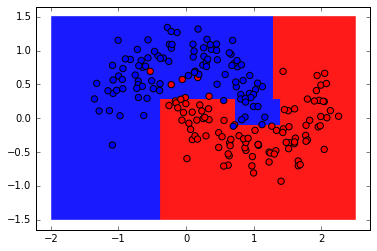

In [26]:
plot_decision_boundary(clf, xmin=-2.0, xmax=2.5, ymin=-1.5, ymax=1.5)

The main difference between regression and classification decision trees is the metrics used to estimate the quality of split. In regression decision tree we used a mean squared error, in classification decision tree we will use Gini index, cross-entropy or misclassification rate:

In [35]:
class ClassificationTree():
    def __init__(self, X, y, error_type='gini', max_depth=5, min_samples_leaf = 1):
        self.X = X
        self.y = y
        self.error_type = error_type        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.nodes = []
        mu, err = self.error(y)
        self.nodes.append(Node(0, [x for x in range(X.shape[0])], mu, err))
        self.nodes_to_split = [0]
    
    def error(self, y):
        p = np.mean(y)
        if self.error_type == 'entropy':
            p = np.clip(p, 0.01, 0.99)
            return p, -1.0*p*np.log(p)-(1-p)*np.log(1-p)
        elif self.error_type == 'gini':
            return p, 2.0*p*(1.0-p)
        elif self.error_type == 'misclass':
            return p, min(p, 1-p)
    
    def split_next_node(self):
        if len(self.nodes_to_split) == 0:
            return
        node = self.nodes[self.nodes_to_split[0]]
        del self.nodes_to_split[0]
        if (node.depth >= self.max_depth or len(node.samples)<=2*self.min_samples_leaf-1 or node.error == 0.0):
            node.left = None
            node.right = None
            return
        best_j = -999
        best_t = -999
        best_weighted_err1 = node.error*len(node.samples)
        best_weighted_err2 = node.error*len(node.samples)
        best_mu1 = -999
        best_mu2 = -999
        for j in range(self.X.shape[1]):
            Xj = self.X[node.samples,j]
            #for t in sorted(np.unique(Xj))[self.min_samples_leaf:(-self.min_samples_leaf)]:
            Xj_min = np.min(Xj)
            Xj_max = np.max(Xj)
            for t in np.linspace(Xj_min, Xj_max, 300):
                y_left = self.y[node.samples][Xj<t]
                y_right = self.y[node.samples][Xj>=t]
                if (len(y_left)<self.min_samples_leaf or len(y_right)<self.min_samples_leaf):
                    continue
                mu1, err1 = self.error(y_left)
                mu2, err2 = self.error(y_right)
                weighted_err1 = err1*len(y_left)
                weighted_err2 = err2*len(y_right)
                if (weighted_err1 + weighted_err2) < (best_weighted_err1 + best_weighted_err2):
                    best_j = j
                    best_t = t
                    samples_left = node.samples[Xj<t]
                    samples_right = node.samples[Xj>=t]
                    best_mu1 = mu1
                    best_mu2 = mu2
                    best_err1 = err1
                    best_err2 = err2
                    best_weighted_err1 = weighted_err1
                    best_weighted_err2 = weighted_err2
        if best_j == -999:
            node.left = None
            node.right = None
        else:
            node.left = Node(len(self.nodes), samples_left, best_mu1, best_err1, node)
            node.right = Node(len(self.nodes)+1, samples_right, best_mu2, best_err2, node)
            node.j = best_j
            node.t = best_t
            self.nodes.append(node.left)
            self.nodes.append(node.right)
            self.nodes_to_split.append(len(self.nodes)-2)
            self.nodes_to_split.append(len(self.nodes)-1)
    
    def predict(self, X, probability = False):
        preds = []
        for i in range(X.shape[0]):
            node = self.nodes[0]
            while True:
                if node.j is None:
                    preds.append(node.prediction)
                    break
                if X[i, node.j] < node.t:
                    node = node.left
                else:
                    node = node.right
        if probability == False:
            preds = np.round(preds)
        return np.array(preds)

    def save_tree_to_dot(self, filename):
        def get_edge(x):
            if x.j is None:
                label = 'error = ' + str(np.round(x.error,3)) + '\n samples = ' + str(len(x.samples)) + '\n prob = ' + str(np.round(x.prediction,3))
                if x.prediction > 0.5:
                    color = 'red'
                else:
                    color = 'blue'
            else:
                label = 'X[' + str(x.j) + '] < ' + str(np.round(x.t, 3)) + '\n error = ' + str(np.round(x.error,3)) + '\n samples = ' + str(len(x.samples)) + '\n prob = ' + str(np.round(x.prediction,3))
                color = 'white'
            if x.father_node is None:
                return str(x.id) + ' [ style=filled fillcolor=' + color + ' label="' + label + '"] ;\n'
            else:
                return str(x.id) + ' [ style=filled fillcolor=' + color + ' label="' + label + '"] ;\n' + str(x.father_node.id) + ' -> ' + str(x.id) + ' ;\n' 

        f = open(filename, 'w')
        f.write('digraph Tree {\n node [shape = box] ;\n')
        for x in tree.nodes:
            f.write(get_edge(x))
        f.write('}')
        f.close()

In [45]:
tree = ClassificationTree(X_train, y_train, error_type='gini', max_depth=10, min_samples_leaf = 4)
while len(tree.nodes_to_split)>0:
    tree.split_next_node()
tree.save_tree_to_dot('classification_tree_manual.dot')

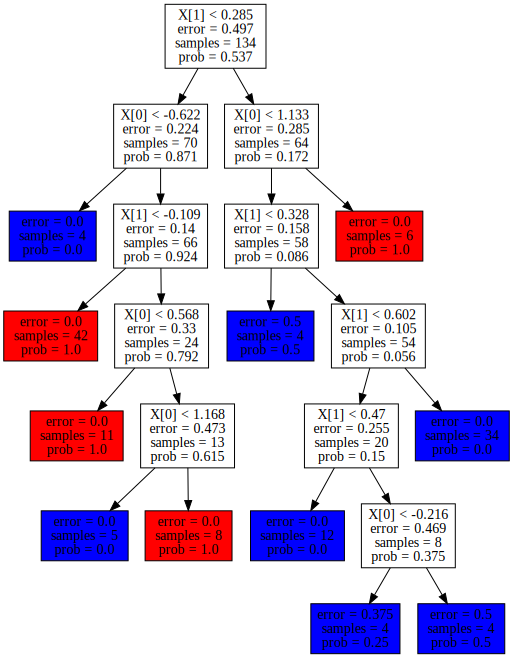

In [46]:
dot = Source(open('classification_tree_manual.dot').read())
dot

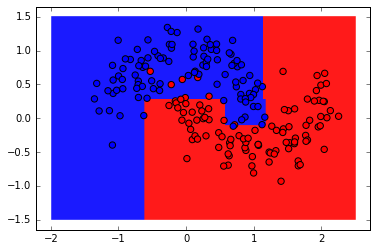

In [47]:
plot_decision_boundary(tree, xmin=-2.0, xmax=2.5, ymin=-1.5, ymax=1.5)

# Gradient trees boosting (XGBOOST)

We will use the same Boston data from scikit-learn package.

In [3]:
boston = ds.load_boston()
X = boston.data
y = boston.target/50.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
print 'Number of training examples: ' + str(X.shape[0])
print 'Number of features: ' + str(X.shape[1])

Number of training examples: 506
Number of features: 13


Now we train the gradient trees boosting model implemented in the package xgboost:

In [5]:
import xgboost as xgb

param = {}
param['objective'] = 'reg:linear'
param['eta'] = 0.03
param['max_depth'] = 10
param['eval_metric'] = 'rmse'
param['silent'] = 1
param['nthread'] = 8
param['gamma'] = 1.0
#param['alpha'] = 1.0
param['lambda'] = 0.0
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 1.0
num_round = 1000
param['seed'] = 2657
plst = list(param.items())

xgmat_train = xgb.DMatrix(X_train, label=y_train, missing = -999.0)
bst = xgb.train( plst, xgmat_train, num_round );
xgmat_test = xgb.DMatrix(X_test, missing = -999.0)
y_pred = bst.predict( xgmat_test )
print rmse(y_test, y_pred)

0.108290326706
